In [3]:
from functions import *

Some more work expected at TS_Class and Data_Explorer, others used as imported from functions.

TO DO: 
* reorganize code - move plotting to Plotting class, order methods in meaningful way, ancillary methods under the main ones in which they are applied
* finish the docstrings
* make a list of attributes of each class in the class docstring
* decide about public and non-public methods, add "\_" to the beginning of the non-public methods' names

In [4]:
#print(vars(ts_data).keys())

In [5]:
#[ x for x in dir(ts_data) if not x.startswith("_")]

In [6]:
#[ x for x in dir(TS_Class) if not x.startswith("_")]

In [113]:
class TS_Class:
    """
    Time Series Class for handling and analyzing time series data. 
    Main functionalities are:
        - classification of events present in the time series
        - replacement of values from events with the corrected values
        - plotting data in wide variety of ways, including plotting of chosen subsets, with chosen periodicity, 
        with variety of statistical measures and multiple variables at once in the same graph or side-by-side
        - plotting of the data with denoted events, and of comparison between the original and corrected data 

    Args:
    data (pandas.DataFrame): The input time series data containing a column with dates and the main variable column.
    main_var (str): The main variable to analyze within the provided data. Defaults to "Prietok".
    start_date (str or datetime-like): The start datetime for the analysis. If not specified, defaults to the minimum date in the 'date' column.
    end_date (str or datetime-like): The end datetime for the analysis. If not specified, defaults to the maximum date in the 'date' column.
    periodicity (str): The desired periodicity for the time series data. Defaults to "2T" (2 minutes).
    check_per (bool): If True, ensures constant periodicity in observations. Defaults to True.
    date_col (str): Name of the column containing dates. Defaults to "date".

    Attributes:
    periodicity (str): The specified periodicity for the time series data.
    start_date (str): The earliest datetime in the data.
    end_date (str): The latest datetime in the data.
    data (pandas.DataFrame): The time series data which is analyzed.
    check_per (bool): Indicates whether ensuring constant periodicity in observations is desired.  *non-public
    main_var (str): The main variable to analyze within the provided data.
    models (dict): A dictionary to store models for the time series data.
    plotter (Plotter): An instance of the Plotter class used for plotting figures based on the provided data.   *non-public?
    period_data (pandas.groupby): Grouped data based on the specified period.     *non-public?
    period_data_2 (pandas.groupby): Grouped data based on the specified period.     *non-public?

    """
    DEFAULT_CLASSIF_PARAMS = {"data": None, "classif_var": None, "W_0": 3,
                              "c_1": 2.5, "W_1": 30,
                              "c_2": 1, "W_2": 30, "p_1": 0.7,
                              "W_3": 5, "p_2": 0.9,
                              "tol_vol_1": 5, "tol_vol_2": 5,
                              "tol_rain_1": 5, "tol_rain_2": 10,
                              "volatile_diffs": True}
    
    def __init__(self, data, main_var="prutok_computed", start_date=None, end_date=None, periodicity="2T", check_per=True, 
                 date_col="date", name="some_TS"):
        """Please see help(TS_Class) for further information."""
        self.name = name
        if start_date is None:
            start_date = data[date_col].min()       
        if end_date is None:
            end_date = data[date_col].max()        
        self.periodicity = periodicity
        
        self.data = data.copy()
        if date_col != "date":
            self.data["date"] = self.data[date_col]
        if check_per:       # ensuring we have constant periodicity in observations
            self.enforce_periodicity(start_date, end_date, periodicity)
        self.start_date = self.data["date"].min()
        self.end_date = self.data["date"].max()
        
        self.check_per = check_per
        self.main_var = main_var
        self.models = {}
        self.plotter = Plotter(self) 
        self.period_data = None
        self.period_data_2 = None
        # automatically add first and second differences of the main variable
        self.data[main_var + "_diff_1_"] = self.data[main_var].diff()
        self.data[main_var + "_diff_2_"] = self.data[main_var + "_diff_1_"].diff()
        
    
    def enforce_periodicity(self, start_date=None, end_date=None, periodicity=None):
        """
        Ensures constant periodicity in class's data within specified datetimes interval and periodicity.

        Args:
        start_date (str): The start date for ensuring constant periodicity. If None, defaults to the class's start date.
        end_date (str): The end date for ensuring constant periodicity. If None, defaults to the class's end date.
        periodicity (str): The desired periodicity for ensuring constant periodicity. If None, defaults to the class's periodicity.

        Notes:
        This method modifies the class's data attribute to enforce constant periodicity.
        It generates a date range based on provided or default start and end dates using the specified or default periodicity
        and merges it with the existing data, deleting observations with non-conforming datetimes and creating NaN observations 
        for missing datetimes in the process. This ensures data is observed at regular intervals within desired datetime range.
        
        """
        if start_date is None: start_date = self.start_date
        if end_date is None: end_date = self.end_date
        if periodicity is None: periodicity = self.periodicity
        # create dataframe with prescribed datetimes 
        date_range = pd.date_range(start=start_date, end=end_date, freq=periodicity)
        df = pd.DataFrame({'date': date_range})
        # left join - creates NaN values for missing datetimes and deletes non-comforming datetimes
        self.data = df.merge(self.data, on='date', how='left')
        self.periodicity = periodicity
        self.start_date = start_date
        self.end_date = end_date
        
    def cut_data(self, start_date, end_date):
        if start_date is None: start_date = self.start_date
        if end_date is None: end_date = self.end_date
        subset = (self.data['date'] >= start_date) & (self.data['date'] <= end_date)
        self.data = self.data.iloc[subset,]
        self.start_date = self.data['date'].min()
        self.end_date = self.data['date'].max()
        
    
    def copy(self, **kwargs):
        """
        Creates a deep copy of the current TS_Class instance with optional modifications of the initialization parameters.
        If not stated otherwise with the keyword arguments, the current corresponding attributes of the TS_Class instance 
        will be used for the initialization.

        Args:
        **kwargs: Optional modifications of the initialization parameters of the new TS_Class instance.
    
        Returns:
        TS_Class: A new instance of TS_Class initialized with a copy of the current data and parameters.
        
        """
        data_copy = self.data.copy()
        params = {"data": data_copy, "main_var": self.main_var, # default values of initialization parameters
                 "start_date": self.start_date, "end_date": self.end_date, 
                 "periodicity": self.periodicity, "check_per": self.check_per, 
                 "date_col": "date", "name": self.name+"_copy"}
        for arg, value in kwargs.items():  # replace default values of initialization parameters
            params[arg] = value
        self_copy = TS_Class(**params)
        return self_copy
       
    
    def plot(self, *args, **kwargs):
        output = self.plotter.plot(*args, **kwargs)  # gives None if ret_plots argument is False
        return output  
                   
    
    def groupby(self, groupby):
        if groupby is None:
            self.data["__const"] = "whole data"
            grouped = self.data.groupby("__const")
        else:
            if groupby == "daily":
                self.data['period_name'] = self.data['date'].dt.date
                grouped = self.data.groupby("period_name")
            elif groupby == "weekly":
                self.data['period_name'] = self.data['date'].dt.strftime('%Y-%W')
                grouped = self.data.groupby("period_name")
            else:
                grouped = self.data.groupby(groupby)
        return grouped
    
    
    def get_period_data(self, period, start_time=None, which=1, subset=None):
        """
        Retrieves data grouped by specified datetime period and assigns it to period_data or period_data_2 attribute. 
        Denotes each group by its start and end datetimes or, for daily period, its date.
        
        Args:
        period (str or int): Length of the period for grouping data. Can be 'daily', 'weekly', or a whole number indicating number of hours.
        start_time (str or None): The start time for hourly grouping. Needs to be eqaul to 'start' or compatible with "%H:%M:%S" format and present in the data.
                                  If None, defaults to the earliest timestamp in the data; same for 'start'.
        which (int): Indicates to which attribute the grouped data are assigned. If 1 it uses self.period_data, else it uses
                     self.period_data_2. Defaults to 1.
        subset (list or None): Subset of data indices to consider. If None, uses the entire data.
        
        Result:
        pandas.core.groupby.DataFrameGroupBy: A grouped DataFrame object based on the specified period. 
                                              Assigned to period_data or period_data_2 attribute.

        Raises:
        NameError: If an unrecognized period is entered. Expected an integer value, 'weekly' or 'daily'.
        
        """
        used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
        
        if type(period) == int:    # integer number of hours as period length 
            if start_time is None or start_time == "start":
                reference_point = used_data["date"].min()
            else:
                start_time = datetime.strptime(start_time, "%H:%M:%S")
                reference_point = used_data[used_data['date'].dt.time == start_time.time()]["date"].min() # choose the earliest observation with given time
                used_data = used_data[used_data["date"]>= reference_point]    # cut off observations before start_time
            
            # indicate for each observation in which period it lays and give periods their name based on their starting and end datetimes
            used_data["period_index"] = used_data["date"].apply(lambda x: (x-reference_point).total_seconds() // (period * 3600))
            used_data["period_name"] = used_data["period_index"].apply(
                lambda x:f"[{reference_point + timedelta(hours=period*x)} -- {reference_point + timedelta(hours=period*(x+1))})")
        
        elif period == "daily":
            used_data['period_name'] = used_data['date'].dt.date  # differentiate individual days
            
        elif period == "weekly":
            first = used_data['date'].dt.strftime('%Y-%W').apply(  # get the year and the week number and...
                lambda x: x.split("-")).apply(
                lambda y: datetime.strptime(f'{y[0]}-W{y[1]}-1', "%Y-W%U-%w") )  # ...get the date of Monday for given week
            used_data['period_name'] = first.apply(  # name each week as dates of its first_day -- last_day
                lambda x: f"{x.strftime('%Y-%m-%d')} -- {(x+timedelta(days=6)).strftime('%Y-%m-%d')}")
                       
        else:
            raise NameError('Period which is not recognized have been entered. Integer value, "weekly" or "daily" are expected.')
        
        if which == 1:
            self.period_data = used_data.groupby('period_name')
        else:
            self.period_data_2 = used_data.groupby('period_name')
        
    
    def create_measures(self, variable, include, window, which=1, b_mult=1, quantile=0.5, 
                     rob_quantile=0.8, two_sided_rob_q=False, rob_b_mult=1): 
        """
        Calculates various statistical measures including rolling averages, standard deviations, quantiles, etc.
        
        Moving measures can be centred or backwards-looking. Robust measures are calculated based on robust subset of data,
        please refer to documentation of get_rob_subset method for more information.
        Possible measures:
        - 'CMA': Centered Moving Average
        - 'CMA_bounds': N Centred Moving Standard Deviations bounds around Centered Moving Average, N = b_mult
        - 'CMA_bounds_2sd': Two Centred Moving Standard Deviations bounds around Centered Moving Average
        - 'CMA_rob_bounds': M Robust (Overall) Standard Deviations bounds around Centered Moving Average, M = rob_b_mult 
        - 'MA': Backwards looking Moving Average
        - 'MA_bounds': N backwards looking Moving Standard Deviations bounds around backwards looking Moving Average, N = b_mult 
        - 'MA_bounds_2sd': Two backwards looking Moving Standard Deviations bounds around backwards looking Moving Average 
        - 'MA_rob_bounds': M Robust (Overall) Standard Deviations bounds around backwards looking Moving Average, M = rob_b_mult 
        - 'CMSD': Centered Moving Standard Deviation
        - 'MSD': Backwards looking Moving Standard Deviation
        - 'tot_avg': Total Average
        - 'quant': Overall Quantile value specified by 'quantile'
        - 'robust_avg': Overall Average based on the robust subset

        Args:
        variable (str): The variable column to consider for calculating statistical measures.
        include (list): A list of strings indicating which measures to include. 
                        Options: 'CMA', 'CMA_bounds', 'CMA_bounds_2sd', 'CMA_rob_bounds', 'MA', 'MA_bounds',
                        'MA_bounds_2sd', 'MA_rob_bounds', 'CMSD', 'MSD', 'tot_avg', 'quant', 'robust_avg'.
        window (int): The window size for calculations of moving measures.
        which (int): Specifies suffix of resulting measures. Used when plotting 2 side-to-side graphs. Defaults to 1.
        b_mult (float): Multiplier for standard deviations bounds. Defaults to 1 (One SD bound).
        quantile (float): Quantile for displaying quantile measure. Defaults to 0.5.
        rob_quantile (float): Quantile for calculations of robust measures. Defaults to 0.8.
        two_sided_rob_q (bool): If True, considers symmetric rob_quantile range for robust measures. Defaults to False.
        rob_b_mult (float): Multiplier for robust bounds. Defaults to 1 (One Robust-SD bound).

        Notes:
        Robust measures are based on the overall statistics for data subset created by eliminating observations with 
        variable's values above the variable's rob_quantile / outside the variable's (1-rob_quantile)/2 to rob_quantile/2 range. 
        In the latter case, the value 0.5+rob_quantile/2 enters as the argument into get_rob_subset method. See get_rob_subset method documentation for more details.
        
        """
        suff = "" if which == 1 else "_2"  # suffix for saving the measures in the data
        if two_sided_rob_q:
            rob_quantile = 0.5 + rob_quantile/2  # adjust argument for correct use in get_rob_subset method
        
        if "CMA" in include:
            self.data['__Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
        if ("CMA_bounds" in include) or ("CMA_bounds_2sd" in include):
            self.data['__Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
            self.data['__Centered_Moving_SD'+suff] = self.data[variable].rolling(window=window, center=True).std()
            self.data['__CMA_upper'+suff] = self.data['__Centered_Moving_Average'+suff] + b_mult*self.data['__Centered_Moving_SD'+suff]
            self.data['__CMA_lower'+suff] = self.data['__Centered_Moving_Average'+suff] - b_mult*self.data['__Centered_Moving_SD'+suff]
            if "CMA_bounds_2sd" in include:  # same as using b_mult=2
                self.data['__CMA_upper_2sd'+suff] = self.data['__Centered_Moving_Average'+suff] + 2*self.data['__Centered_Moving_SD'+suff]
                self.data['__CMA_lower_2sd'+suff] = self.data['__Centered_Moving_Average'+suff] - 2*self.data['__Centered_Moving_SD'+suff]
        if "CMA_rob_bounds"  in include:
            self.data['__Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q) 
            robust_sd = self.data[subset][variable].std()  # overall std on the robust subset
            self.data['__CMA_upper_rob'+suff] = self.data['__Centered_Moving_Average'+suff] + rob_b_mult*robust_sd
            self.data['__CMA_lower_rob'+suff] = self.data['__Centered_Moving_Average'+suff] - rob_b_mult*robust_sd
                
        if "MA" in include:
            self.data['__Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
        if ("MA_bounds" in include) or ("MA_bounds_2sd" in include):
            self.data['__Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
            self.data['__Moving_SD'+suff] = self.data[variable].rolling(window=window, center=False).std()
            self.data['__MA_upper'+suff] = self.data['__Moving_Average'+suff] + b_mult*self.data['__Moving_SD'+suff]
            self.data['__MA_lower'+suff] = self.data['__Moving_Average'+suff] - b_mult*self.data['__Moving_SD'+suff]
            if "MA_bounds_2sd" in include:  # same as using b_mult=2
                self.data['__MA_upper_2sd'+suff] = self.data['__Moving_Average'+suff] + 2*self.data['__Moving_SD'+suff]
                self.data['__MA_lower_2sd'+suff] = self.data['__Moving_Average'+suff] - 2*self.data['__Moving_SD'+suff]
        if "MA_rob_bounds" in include:
            self.data['__Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            robust_sd = self.data[subset][variable].std()   # overall std on the robust subset
            self.data['__MA_upper_rob'+suff] = self.data['__Moving_Average'+suff] + rob_b_mult*robust_sd
            self.data['__MA_lower_rob'+suff] = self.data['__Moving_Average'+suff] - rob_b_mult*robust_sd
        
        if "CMSD" in include:
            self.data['__Centered_Moving_SD'+suff] = self.data[variable].rolling(window=window, center=True).std()
        if "MSD" in include:
            self.data['__Moving_SD'+suff] = self.data[variable].rolling(window=window, center=False).std()
        if "tot_avg" in include:
            self.data['__total_avg'+suff] = self.data[variable].mean()
        if "quant" in include:
            self.data['__quantile'+suff] = self.data[variable].quantile(quantile)
        if "robust_avg" in include:
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            self.data['__r_avg'+suff] = self.data[subset][variable].mean()
            
            
    def get_rob_subset(self, variable, rob_quantile, two_sided):
        """
        Generates indicators for data subsetting based on a specified variable and quantile with the goal to eliminate observations 
        which have variable's values above this quantile or outside the symmetric 1-2*quantile range.

        Args:
        variable (str): The variable column to consider for subset creation.
        rob_quantile (float): The quantile value (between 0 and 1) for subset selection.
        two_sided (bool): If True, subsets values between quantile and 1-quantile. Else, subsets values below the quantile.

        Returns:
        pandas.Series: A boolean Series indicating the subset based on the specified variable and quantile.
        
        """
        subset = self.data[variable] < self.data[variable].quantile(rob_quantile)
        if two_sided:
            L = self.data[variable].quantile(min(1-rob_quantile,rob_quantile))
            U = self.data[variable].quantile(max(1-rob_quantile,rob_quantile))
            subset =  self.data[variable].apply(lambda x: L<x<U)
        return subset      
    
    
    def classify(self, **kwargs):       
        params = self.DEFAULT_CLASSIF_PARAMS.copy()
        
        for arg, val in kwargs.items():  # change default classification parameters based on input
            params[arg] = val
        
        ret = True # if data is self.data, classification output will change self.data attribute, else it will be returned as method output
        if params["data"] is None: 
            params["data"] = self.data
            ret = False    
        if params["classif_var"] is None:
            params["classif_var"] = self.main_var
            
        data = classify(**params)
        if not ret:
            self.data = data
        else:
            return data
    
    def plot_categories(self, **kwargs):
        self.plotter.plot_categories(**kwargs)


    ## models ##
    def get_ETS(self, variable, model_name, groupby = None, show_progress = True,
                error="add", trend="add", seasonal="add", damped_trend=False, seasonal_periods=720):
        """Note: there is 720 observations per day, for 1 day periodicity we need 720 seasonal components, which is too 
        many for practical estimatation - careful about seasonal components."""
        self.data[model_name + "_fitted"] = np.nan
        self.models[model_name] = []
        i = -1
        grouped = self.groupby(groupby)
                        
        length = len(grouped)
        for unit, grouped_data in grouped:
            model = ETSModel(grouped_data[variable], error=error, trend=trend, seasonal=seasonal, 
                                            damped_trend=damped_trend, seasonal_periods=seasonal_periods)
            result = model.fit()
            grouped_data[model_name + "_fitted"] = result.fittedvalues
            self.models[model_name].append((unit, model, results))
            self.data.loc[grouped_data.index,model_name + "_fitted"] = grouped_data[model_name + "_fitted"]
            if show_progress:
                i += 1
                if i%5 == 0:
                    print(f"{i+1} out of {length} ({(i+1)*100/length}%)")
                    
    def get_ARIMA(self, p, d, q, model_name, variable = None,  groupby = None, show_progress = True):
        if variable is None: variable = self.main_var
        self.data[model_name + "_fitted"] = np.nan
        self.models[model_name] = []
        i = -1
        grouped = self.groupby(groupby)           
        length = len(grouped)
        for unit, grouped_data in grouped:
            model = ARIMA(grouped_data[variable], order=(p, d, q))
            results = model.fit()
            grouped_data[model_name + "_fitted"] = results.fittedvalues
            self.models[model_name].append((unit, model, results))
            self.data.loc[grouped_data.index,model_name + "_fitted"] = grouped_data[model_name + "_fitted"]
            if show_progress:
                i += 1
                if i%5 == 0:
                    print(f"{i+1} out of {length} ({(i+1)*100/length}%)")
                    
    def ARIMA_diagnostics(self, results, unit, model_name, show_summary = True):
        print("ARIMA diagnostics for " + model_name + " " + str(unit))
        if show_summary:
            print(results.summary())
        residuals = results.resid
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        ax[0, 0].plot(residuals)
        ax[0, 0].set_title('Residuals')
        lags_1 = min(40, len(residuals)-1)
        lags_2 = min(40, int(len(residuals)/2)-2)
        sm.graphics.tsa.plot_acf(residuals, lags=lags_1, ax=ax[0, 1])
        sm.graphics.tsa.plot_pacf(residuals, lags=lags_2, ax=ax[1, 0])
        plt.show()

        # Ljung-Box test for autocorrelation in residuals
        acf, q_val, p_val = sm.tsa.acf(residuals, fft=True, qstat=True)
        p_val_df = pd.DataFrame({'Lag': range(1, len(p_val) + 1), 'P-Value': p_val})

        print(p_val_df)
    
    def ARIMAs_diagnostics(self, model_name, subset = None):
        models = self.models[model_name]
        if subset is not None:
            models = models[subset]
        for unit, mod, res in models:
            self.ARIMA_diagnostics(res, unit, model_name)
            
    
    @staticmethod
    def time_trend(values, give="slope", degree=1, centred=True):
        """
        Estimates polynomial time trend. Slope estimate thus gives estimate of time derivation at time=0 (globally for degree=1).
        Meant to be used on the roling windows, time zero should thus be at the center or at the end of the given data series.
        Values should have a data series format with specified index which represents time order.
        
        
        Examples:
        trend = TS_Class.time_trend
        deriv_deg_1_est = ts_obj.data[var].rolling(30, center=True).apply(trend)
        deriv_deg_2_est = ts_obj.data[var].rolling(30, center=True).apply(lambda x: trend(x, degree=2))
        last_obs_deriv_deg_3_est = ts_obj.data[var].rolling(50, center=False).apply(lambda x: trend(x, degree=3, centred=False))
        """
        if centred:
            center = int(len(values.index)/2)
        else:
            center = -1
        time = values.index - values.index[center]   # we take t=0 at the end or in the center of the provided data
        x = np.array(time)
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        x_poly = poly_features.fit_transform(x.reshape(-1, 1))
        
        model = LinearRegression(fit_intercept=True)
        model.fit(x_poly, values)
        
        if give == "slope":
            return model.coef_[0]
        if give == "constant":
            return model.intercept_
        if give == "model":
            return model
        
    

In [114]:
class Plotter:
    
    def __init__(self, TS_object):
        self.ts = TS_object
        self.data = TS_object.data
        
        
    def plot(self, variable=None, include=["CMA", "CMA_bounds"], rain_var=None,
             period="all", start_time=None, subset=None,
             window=30,  b_mult=1, quantile=0.5,
             rob_quantile=0.8, two_sided_rob_q=False, rob_b_mult=1,
             rain_lims=(0,5), fig_size=None,
             variable_2=None, include_2=["CMA", "CMA_bounds"], start_time_2=None, 
             window_2=30, b_mult_2=1, quantile_2=0.5, 
             rob_quantile_2=0.8, two_sided_rob_q_2=False, rob_b_mult_2=1, 
             marker=None, show=True, ret_plots=False):
        """
        Plot method to visualize time series contained in the data.
        
        Mutliple time series can be plotted alongside the given variable in the same figure by listing them in the include 
        argument. Time series can be divided to smaller time periods which are plotted in seperate figures by specifying
        period argument. Argument start_time specifies at what time of a day should plotting of figure(s) start in the case 
        the period is given as an integer representing length of a period in number of hours. In that case observations before 
        the first instance of given time will be disregarded. Measures created by create_measures method (of TS_Class) can
        be listed in include, see create_measures method for more information.
        If start_time_2 argument is not None, two (sets of) figures will be drawn side-by-side, the figure(s) on the right 
        handside will be specified by arguments with the "_2" suffix.

        Args:
        variable (str): Variable to plot. Defaults to main_var of the corresponding TS_Class instance if None.
        include (list[str]): List of statistical measures and other variables to include in the plot. Defaults to ['CMA', 'CMA_bounds'].
        rain_var (str or None): Name of the variable containing rain data. If not None the rain will be plotted on the right-handside axis upside-down.
                                Defaults to None.
        period (str): Length of period to plot in a single figure. Can be 'all', 'daily', 'weekly', or a whole number indicating number of hours. 
                      Defaults to 'all' for plotting the whole time series in one figure.
        start_time (str): Starting time for plotting of the data. Needs to be 'start' or compatible with "%H:%M:%S" format and present in the data.
                          Defaults to time of the earliest observation in the data if None. Active only if period is integer.
        subset (list or slice): Subset of data indeces to consider. Defaults to the whole data if None.
        window (int): Window size for calculations of moving measures. Defaults to 30.
        b_mult (int or float): A multiplier parameter indicating size of the moving standard deviations bound. Defaults to 1.
        quantile (float): Indicates which quantile of the variable should be plotted value. Should be between 0 and 1. Defaults to 0.5
        rob_quantile (float): Indicates on which quantile calculations of robust measures should be based. See get_rob_subset method of TS_Class class 
                              for more information. Defaults to 0.8.
        two_sided_rob_q (bool): If True, considers symmetric rob_quantile range for robust measures. See get_rob_subset method of TS_Class class 
                                for more information. Defaults to False.
        rob_b_mult (int or float): A multiplier parameter indicating size of the robust standard deviations bound. Defaults to 1.
        rain_lims (tuple): Limits for the right-handside y-axis when the rain_var is not None. Defaults to (0, 5).
        fig_size (tuple): Size of the plotted figure(s). If None, defaults to (19, 6) for side-by-side drawing of two (sets of) figures or (10, 6) otherwise.
        marker (str): Marker style for the plots. Defaults to None.
        show (bool): Whether to display the plot(s). Defaults to True.
        ret_plots (bool): Whether to return the list of constructed figure(s) as output. Defaults to False.
        variable_2 (str): Variable to plot on the right-handside (set of) figure(s). Defaults to the same as variable if None.
        start_time_2 (str): Starting time for plotting of the right-handside data. Needs to be 'start' or compatible with "%H:%M:%S" format and present in the data.
                            If None, only left-handside (set of) figure(s) is plotted. If 'start', time of the earliest observation in the data is chosen. 
                            If not None but period is not integer the use is the same as for 'start'. Defaults to None.
                          
        Other arguments with suffix "_2" are analogous to the above. Arguments period, subset, rain_var and marker are shared
        for both left and right-handside (sets of) figures.

        Returns:
        None or list[tuple]: If ret_plots is True and start_time_2 is not None, returns a list of tuples (fig, ax, axb1, axb2).
                             If ret_plots is True and start_time_2 is None, returns a list of tuples (fig, ax, axb1).
                             Otherwise, returns None.

        """
        if variable is None:
            variable = self.ts.main_var
        
        self.ts.create_measures(variable, include, window,  # prepare required statistical measures
                                which=1, quantile=quantile, b_mult=b_mult, 
                                rob_quantile=rob_quantile, two_sided_rob_q=two_sided_rob_q, rob_b_mult=rob_b_mult) 
        
        if start_time_2 is not None:  # if plotting also right-handside figures
            if variable_2 is None: 
                variable_2 = variable
            self.ts.create_measures(variable_2, include_2, window_2,  # prepare required statistical measures for right-handside figures
                                    which = 2, quantile = quantile_2, b_mult=b_mult_2,
                                    rob_quantile = rob_quantile_2, two_sided_rob_q = two_sided_rob_q_2, rob_b_mult = rob_b_mult_2)
                
        if period == "all":
            self.data["__const"] = "whole data"
            used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
            self.ts.period_data = used_data.groupby("__const")  # assign as groupby object for code consistency
        else:
            self.ts.get_period_data(period, start_time, 1, subset)  # create subdata for each plotting period
        
        if start_time_2 is None:
            self.ts.period_data_2 = self.ts.period_data  # for ensuring period_data_2 is never None
        else:     # divide data to periods for right-handside figures
            if period == "all":
                self.data["__const"] = "whole data"
                used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
                self.ts.period_data_2 = used_data.groupby("__const")
            else:
                self.ts.get_period_data(period, start_time_2, 2, subset)
        
        output = []
        for grouped_1, grouped_2 in zip(self.ts.period_data, self.ts.period_data_2):  # iterate through all periods
            unit_1, group_data_1 = grouped_1    # get list-like of period names and list-like of period subsets
            unit_2, group_data_2 = grouped_2
                       
            if start_time_2 is not None:
                if fig_size is None: 
                    fig_size = (19, 6)
                fig, ax = plt.subplots(1, 2, figsize=fig_size)  # 2 figures in 1 row
                # assign to each figure its properties, get also right-handside y-axis in both figures if rain is plotted
                ax[0], axb1 = self._get_ax(ax[0], group_data_1, unit_1, variable, include, rain_lims, 1, rain_var, marker)
                ax[1], axb2 = self._get_ax(ax[1], group_data_2, unit_2, variable_2, include_2, rain_lims, 2, rain_var, marker)
            else:
                if fig_size is None: 
                    fig_size = (10, 6)
                fig, ax = plt.subplots(figsize=fig_size)
                # assign to figure its properties, get also right-handside y-axis if rain is plotted
                ax, axb1 = self._get_ax(ax, group_data_1, unit_1, variable, include, rain_lims, 1, rain_var, marker)
            
            plt.grid(True)
            if show:
                plt.show()
            
            if ret_plots:  # add figures to the output list
                if start_time_2 is not None:
                    output.append((fig, ax, axb1, axb2))
                else:
                    output.append((fig, ax, axb1))
        if ret_plots:
            return output
            
    def plot_categories(self, categories="all", classif_var=None, only_events=False,
                        period="all", start_time=None, subset=None, fig_size=None):
        if classif_var is None:
            classif_var = self.ts.main_var
        
        if categories == "all":   # make explicit list of events  
            cats_list = list(self.data[classif_var + "_category"].unique())
            if "OK" in cats_list:
                cats_list.remove("OK")
        else:
            cats_list = categories
        
        if period == "all":
            self.data["__const"] = "whole data"
            used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
            self.ts.period_data = used_data.groupby("__const")
        else:
            self.ts.get_period_data(period, start_time, 1, subset)
        
        for grouped in self.ts.period_data:
            unit, group_data = grouped
            plot_this = True
            if only_events:       # plot only when there are events of interest
                plot_this = group_data[classif_var + "_category"].isin(cats_list).any()  
            if plot_this:
                plot_categories(group_data, classif_var, unit, categories, fig_size)    
    
       
    def _get_ax(self, ax, group_data, unit, variable, include, rain_lims, which, rain_var=None, marker=None):  
        suff = "" if which == 1 else "_2"   # for plotting correct pre-prepared measures
        ax.plot(group_data['date'], group_data[variable], label = variable)
        include_c = include.copy()  # so we can delete already plotted measures from the list without altering it for use in future calls 
        
        if "CMA" in include_c:
            ax.plot(group_data['date'], group_data['__Centered_Moving_Average'+suff], color="red", label = "CMA")
            include_c.remove("CMA")
        
        if "CMA_bounds_2sd" in include_c:
            ax.plot(group_data['date'], group_data['__CMA_upper_2sd'+suff], color="orange", label = "CMA_Up")
            ax.plot(group_data['date'], group_data['__CMA_lower_2sd'+suff], color="orange", label = "CMA_L")
            include_c.remove("CMA_bounds_2sd")
        if "CMA_bounds" in include_c:
            ax.plot(group_data['date'], group_data['__CMA_upper'+suff], color="orange", label = "CMA_Up")
            ax.plot(group_data['date'], group_data['__CMA_lower'+suff], color="orange", label = "CMA_L")
            include_c.remove("CMA_bounds")
        
        if "CMA_rob_bounds" in include_c:
            ax.plot(group_data['date'], group_data['__CMA_upper_rob'+suff], color="black", label = "CMA_rob_Up")
            ax.plot(group_data['date'], group_data['__CMA_lower_rob'+suff], color="black", label = "CMA_rob_L")
            include_c.remove("CMA_rob_bounds")
            
        if "MA" in include_c:
            ax.plot(group_data['date'], group_data['__Moving_Average'+suff], color="brown", label = "MA")
            include_c.remove("MA")
        if "MA_bounds" in include_c:
            ax.plot(group_data['date'], group_data['__MA_upper'+suff], color="yellow", label = "MA_Up")
            ax.plot(group_data['date'], group_data['__MA_lower'+suff], color="yellow", label = "MA_L")
            include_c.remove("MA_bounds")
        if "MA_bounds_2sd" in include_c:
            ax.plot(group_data['date'], group_data['__MA_upper_2sd'+suff], color="yellow", label = "MA_Up")
            ax.plot(group_data['date'], group_data['__MA_lower_2sd'+suff], color="yellow", label = "MA_L")
            include_c.remove("MA_bounds_2sd")
        if "MA_rob_bounds" in include_c:
            ax.plot(group_data['date'], group_data['__MA_upper_rob'+suff], color="black", label = "MA_rob_Up")
            ax.plot(group_data['date'], group_data['__MA_lower_rob'+suff], color="black", label = "MA_rob_L")
            include_c.remove("MA_rob_bounds")
            
        if "CMSD" in include_c:
            ax.plot(group_data['date'], group_data['__Centered_Moving_SD'+suff], color="green", label = "CMSD")
            include_c.remove("CMSD")
        if "MSD" in include_c:
            ax.plot(group_data['date'], group_data['__Moving_SD'+suff], color="black", label = "MSD")
            include_c.remove("MSD")
        if "tot_avg" in include_c:
            ax.plot(group_data['date'], group_data['__total_avg'+suff], color="black", label = "tot_avg")
            include_c.remove("tot_avg")
        if "quant" in include_c:
            ax.plot(group_data['date'], group_data['__quantile'+suff], color="black", label = "quantile")
            include_c.remove("quant")
        if "robust_avg" in include_c:
            ax.plot(group_data['date'], group_data['__r_avg'+suff], color="black", label = "robust_avg")
            include_c.remove("robust_avg")
        
        max_y = group_data[variable].max()     # for establishing y-axis limits
        min_y = group_data[variable].min()
        
        for item in include_c:
            if item in group_data.columns:
                ax.plot(group_data['date'], group_data[item], label = item)
                max_y = max(max_y, group_data[item].max())  # for establishing y-axis limits
                min_y = min(min_y, group_data[item].min())
            else:
                warnings.warn(f"{item} not plotted as it was not found in the data.", UserWarning)
                        
        ax.set_title(f'Time Series for {unit}')
        ax.set_xlabel('Date and Time')
        ax.set_ylabel(variable)
        ax.legend(loc="upper left")
        
        ylim_up = self._get_y_lim(max_y)
        ylim_down = -self._get_y_lim(min_y, True) if min_y < 0 else 0  # _get_y_lim returns positive values=>multiply by -1
        ax.set_ylim(ylim_down, ylim_up)
        
        for line in ax.lines:   ### or ax.lines[1:]
            line.set_marker(marker)
            
        if rain_var is not None:
            ax2 = ax.twinx()   # create right-handside y-axis
            ax2.set_ylim(*rain_lims)
            ax2.plot(group_data["date"], group_data[rain_var], label='rain', color='green')
            ax2.invert_yaxis()  # to plot rain upside-down
            ax2.set_ylabel('rain (Upside-Down)', color='green')
            ax2.tick_params(axis='y', labelcolor='green')
            ax2.legend(loc='upper right')
            return (ax, ax2)
        return (ax, "")  # keep the length of output same whether the rain is plotted or not
        
    def _get_y_lim(self, value, negative=False):
        """
        Calculate y-axis limit based on the provided value.
        The method uses a predefined set of conditions to determine the appropriate y-axis limit.

        Args:
        value (float): The input value for determining the y-axis limit.
        negative (bool): If True, the value is considered negative. Defaults to False.

        Returns:
        float: The calculated y-axis limit based on the provided value.
        
        """
        if negative:
            value = - value
        if value < 0.05: return value*1.1
        if value < 0.09: return 0.1
        if value < 0.47: return 0.5
        if value < 0.9: return 1
        if value < 2.45: return 2.5
        if value < 4.9: return 5
        if value < 9.5: return 10
        if value < 19: return 20
        return value*1.1
    
    @staticmethod        
    def show_again(figures):
        for fig in figures:
            new_fig = plt.figure()
            new_manager = new_fig.canvas.manager
            new_manager.canvas.figure = fig
            fig.set_canvas(new_manager.canvas)
            plt.show()
            

In [115]:
class Data_Explorer:
    
    DEFAULT_TS_PARAMS = {}
    
    def __init__(self, datas_dictionary, kwargs_dict={} 
                 ##, main_vars = None, 
                 ##start_dates = None, end_dates = None, periodicities = None, check_pers = None, date_cols=None
                ):
        datas_dictionary = {site: datas_dictionary[site] for site in sorted(datas_dictionary)}  # sort dictionary by keys
        self.data_dict_orig = {site: datas_dictionary[site].copy() for site in datas_dictionary}  # fix the original data for later reference
        self.sites = list(datas_dictionary.keys())
                
        # auxiliary function for checking if init. par. is NOT specified by kwargs_dict  
        dict_check = lambda site_var: (site_var[0] not in kwargs_dict) or (site_var[1] not in kwargs_dict[site_var[0]]) 
        
        # specify TS_Class initialization arguments based on kwargs_dict or as default values
        main_vars = {site: "prutok_computed" if dict_check([site,"main_var"]) or kwargs_dict[site]["main_var"] is None 
                     else kwargs_dict[site]["main_var"] for site in self.sites}
        start_dates = {site: None if dict_check([site,"start_date"]) else kwargs_dict[site]["start_date"] for site in self.sites}
        end_dates = {site: None if dict_check([site,"end_date"]) else kwargs_dict[site]["end_date"] for site in self.sites}
        periodicities = {site: "2T" if dict_check([site,"periodicity"]) or kwargs_dict[site]["periodicity"] is None 
                         else kwargs_dict[site]["periodicity"] for site in self.sites}              
        check_pers = {site: True if dict_check([site,"check_per"]) or kwargs_dict[site]["check_per"] is None
                      else kwargs_dict[site]["check_per"] for site in self.sites}
        date_cols = {site: "date" if dict_check([site,"date_col"]) or kwargs_dict[site]["date_col"] is None
                      else kwargs_dict[site]["date_col"] for site in self.sites}
        ##if main_vars is None: main_vars = {site: "prutok_computed" for site in self.sites}
        ##if start_dates is None: start_dates = {site: None for site in self.sites}
        ##if end_dates is None: end_dates = {site: None for site in self.sites}
        ##if periodicities is None: periodicities = {site: "2T" for site in self.sites}
        ##if check_pers is None: check_pers = {site: True for site in self.sites}
        ##if date_cols is None: date_cols = {site: "date" for site in self.sites}
                
        self.TS_objects = {site: TS_Class(datas_dictionary[site], main_var=main_vars[site],
                                          start_date=start_dates[site], end_date=end_dates[site], 
                                          periodicity=periodicities[site], check_per=check_pers[site], 
                                          date_col=date_cols[site], name=site
                                          ) for site in self.sites}
        
        self.data_dict = {site: self.TS_objects[site].data for site in self.sites}  # pointer to active TS data
        self._joined_data = join_data(self.data_dict)
        self.TS_objects["_joined"] = TS_Class(self._joined_data, main_var=main_vars[self.sites[0]],
                                             start_date=None, end_date=None, periodicity=periodicities[self.sites[0]], 
                                             check_per=False, date_col="date", name="_joined")
        self.main_sites = self.sites.copy()
        self.sites.append("_joined")
        self.data_dict["_joined"] = self.TS_objects["_joined"].data
        
        self.main_vars = {site: self.TS_objects[site].main_var for site in self.sites}
        self.start_dates = {site: self.TS_objects[site].start_date for site in self.sites}
        self.end_dates = {site: self.TS_objects[site].end_date for site in self.sites}
        self.periodicities = {site: self.TS_objects[site].periodicity for site in self.sites}
        self.check_pers = {site: self.TS_objects[site].check_per for site in self.sites}
        
        self.main_dicts_list = ["TS_objects", "data_dict", "data_dict_orig", "main_vars", 
                                "start_dates", "end_dates", "periodicities", "check_pers"]
    
    
    def update_TS_objects(self, add={}, remove=[], from_data_dict=True, add_to_main_sites=True, sort=False):
        if from_data_dict:  # if add contains as values tuples (data, kwargs)
            for site, site_info in add.items():
                data, kwargs = site_info
                if "name" not in kwargs:
                    kwargs["name"] = site
                self.data_dict_orig[site] = data.copy()  # keep current snapshot of data for future reference
                self.TS_objects[site] = TS_Class(data, **kwargs)
                if add_to_main_sites:
                    self.main_sites.append(site)
        
        else:  # if directly as TS_Class instance
            for site, ts_object in add.items():
                self.TS_objects[site] = ts_object
                self.data_dict_orig[site] = ts_object.data.copy() # keep current snapshot of data for future reference
                if add_to_main_sites:
                    self.main_sites.append(site)
        
        if remove is str:
            remove = [remove]
        for site in remove:
            del self.TS_objects[site]
            if site in self.main_sites:
                self.main_sites.remove(site)
        
        if "_joined" in self.TS_objects:
            del self.TS_objects["_joined"]  # current _joined no longer adequate
        
        self.update_main_attrs()   # update other lists and dictionaries based on current TS_objects     
        if sort:
            self.sort()
        
        self._joined_data = join_data(self.data_dict)  # create joined data of all time series
        site_0 = self.sites[0]
        self.TS_objects["_joined"] = TS_Class(self._joined_data, main_var=self.main_vars[site_0],
                                             start_date=None, end_date=None, periodicity=self.periodicities[site_0], 
                                             check_per=False, date_col="date", name="_joined")
        self.update_main_attrs()  # incorporate _joined to main attributes    
               
    
    def update_main_attrs(self):
        self.sites = list(self.TS_objects.keys())
        self.data_dict = {site: self.TS_objects[site].data for site in self.sites}  # pointer to active TS data
        self.main_vars = {site: self.TS_objects[site].main_var for site in self.sites}
        self.start_dates = {site: self.TS_objects[site].start_date for site in self.sites}
        self.end_dates = {site: self.TS_objects[site].end_date for site in self.sites}
        self.periodicities = {site: self.TS_objects[site].periodicity for site in self.sites}
        self.check_pers = {site: self.TS_objects[site].check_per for site in self.sites}
    
    
    def sort(self, key=None, _joined_as_last=True):
        self.main_sites = sorted(self.main_sites, key = key)
        self.sites = sorted(self.sites, key = key)
        if _joined_as_last:
            if "_joined" in self.sites:
                self.sites.remove("_joined")
                self.sites.append("_joined")
        for attr in self.main_dicts_list:
            old_val = getattr(self, attr)
            new_val = {site: old_val[site] for site in self.sites}
            setattr(self, attr, new_val)
            
    
    def classify(self, classif_vars_dict=None, kwargs_dict=None):
        # auxiliary function for extracting kwargs for individual site
        get_kwargs = lambda site: kwargs_dict[site] if (type(kwargs_dict) is dict) and (site in kwargs_dict) else {} 
        output = []
        if classif_vars_dict is None:  # classification of the main_var of the object
            for site in self.main_sites:
                kwargs = get_kwargs(site) 
                output.append(self.TS_objects[site].classify(**kwargs))
        else:  # classification of customarily inputted variables
            for site, classif_var in classif_vars_dict.items():
                kwargs = get_kwargs(site)   # kwargs always the same for the same site
                if type(classif_var) is str:   # classification of 1 variable
                    output.append(self.TS_objects[site].classify(classif_var=classif_var, **kwargs))
                else: # classification of multiple variables 
                    for var in classif_var:  
                        output.append(self.TS_objects[site].classify(classif_var=var, **kwargs))
        # if data which we classify (given by kwargs) is not self.data of corresponding TS object the classified data is returned, else None
        return output 
    
    
    def update_main_vars(self, main_vars_dict={}):
        for site, main_var in main_vars_dict.items():
            self.TS_objects[site].main_var = main_var
        self.main_vars = {site: self.TS_objects[site].main_var for site in self.sites}
        
    def cut_data(self, starts_dict={}, ends_dict={}, periodicities={}):
        for site in periodicities:
            start_date = starts_dict[site] if site in starts_dict else None
            end_date = ends_dict[site] if site in ends_dict else None
            self.TS_objects[site].enforce_periodicity(start_date, end_date, periodicities[site])
        for site in starts_dict:
            if site not in periodicities:
                end_date = ends_dict[site] if site in ends_dict else None
                self.TS_objects[site].cut_data(starts_dict[site], end_date)
        for site in ends_dict:
            if (site not in periodicities) and (site not in starts_dict):
                self.TS_objects[site].cut_data(None, end_date)
        self.update_main_attrs()
    

In [11]:
def classify(data, classif_var="prutok_computed", W_0=3,
             c_1=2.5, W_1=30,
             c_2=1, W_2=30, p_1=0.7,
             W_3=5, p_2=0.9,
             tol_vol_1=5, tol_vol_2=5,
             tol_rain_1=5, tol_rain_2=10,
             volatile_diffs=True):
    data[classif_var + "_category"] = "OK"
    # priority 5
    const = data[classif_var].rolling(window=W_0, center=True).std() == 0
    data.loc[const, classif_var + "_category"] = "const_value"
    
    # priority 4
    if volatile_diffs:    # measure volatility as volatility of first differences
        vol_data = data[classif_var].diff()
    else:                # measure volatility directly on the variable
        vol_data = data[classif_var]
    subset = vol_data <= vol_data.quantile(p_1)
    sd_p_1 = vol_data[subset].std()
    K = c_2*sd_p_1
    sd_2 = vol_data.rolling(window=W_2, center=True).std()
    high_vol_orig = sd_2 > K
    high_vol = join_series(high_vol_orig.astype(int), tol = tol_vol_1, join = 1)  # group nearby islands of volatility
    high_vol = join_series(high_vol, tol = tol_vol_2, join = 0)  # delete small islands of volatility
    high_vol = high_vol.astype(bool)
    data.loc[high_vol, classif_var + "_category"] = "volatile"
    
    # priority 3
    MA = data[classif_var].rolling(window=W_3, center=True).mean()
    rain_threshold = data[classif_var].quantile(p_2)
    rainy = MA >= rain_threshold
    high_vol_rain = high_vol_orig & rainy
    high_vol_rain = join_series(high_vol_rain.astype(int), tol = tol_rain_1, join = 1)  # group nearby islands of rain
    high_vol_rain = join_series(high_vol_rain, tol = tol_rain_2, join = 0)  # delete small islands of rain
    high_vol_rain = high_vol_rain.astype(bool)
    data.loc[high_vol_rain, classif_var + "_category"] = "volatile_rain"
    
    # priority 2
    zeros = data[classif_var] <= 0
    data.loc[zeros, classif_var + "_category"] = "zero_value"
    
    # priority 1
    first_diff = data[classif_var].diff()
    first_diff_plus = first_diff.shift(-1)
    sd_1 = first_diff.rolling(window=W_1, center=True).std()
    T = c_1*sd_1
    outliers = ((first_diff > T) & (first_diff_plus < -T)) | ((first_diff < -T) & (first_diff_plus > T))
    data.loc[outliers, classif_var + "_category"] = "outlier"
    
    dummies = pd.get_dummies(data[classif_var + "_category"], prefix=classif_var)
    for col in dummies.columns:
        data[col] = np.where(dummies[col] == 1, data[classif_var], np.nan)
    #data = pd.concat([data, dummies], axis=1)
    return data

In [133]:
def plot_categories(df, classif_var, unit, categories = "all", fig_size = None):
    
    if categories == "all":
        cats = list(df[classif_var + "_category"].unique())
        if "OK" in cats:
            cats.remove("OK")
    else:
        cats = [cat for cat in categories if (df[classif_var + "_category"] == cat).any()]
    cols = [classif_var + "_" + cat for cat in cats]
    
    if fig_size is None: 
        fig_size = (10, 6)
    plt.figure(figsize=fig_size)
    plt.plot(df['date'], df[classif_var], label=classif_var, color='blue')  # Line plot for var1

    # Plot special categories as scatter plots with different markers
    markers = {"volatile_rain":'o', 'const_value':'s', 'outlier':'^', 'zero_value':'D','volatile':"*"}  # Define markers for each category (max 5 categories)
    colors = ["green", "brown", "red", "yellow", "orange"]
    colors = {key: col for key, col in zip(markers.keys(), colors)}
    for i, column in enumerate(cols):
        cat = cats[i]
        if cat in ["volatile_rain", "volatile"]:
            plt.plot(df['date'], df[column], label=cat, linestyle='-', marker=markers[cat], color = colors[cat])
        else:
            plt.scatter(df['date'], df[column], label=cat, marker=markers[cat], color = colors[cat])

    plt.xlabel('Date and Time')
    plt.ylabel(classif_var)
    plt.title(f'Time Series for {unit}')
    plt.legend()
    plt.show()

## new functions

In [12]:
def identify_groups(indicators):
    groups = (indicators.diff() != 0).cumsum().astype(str)
    groups[indicators] += "_T"
    return groups

In [13]:
def summarize_indicators(indicators):
    out = {}
    out["count"] = indicators.sum()
    out["count_perc"] = indicators.mean()  # count and perc of trues
    groups = (indicators.diff() != 0).cumsum()   # identify in which group of successive Trues or Falses an observation lies
    groups_sizes = indicators.groupby(groups).transform('size')
    
    true_groups = groups[indicators]
    out["no_groups"] = len(true_groups.unique())  # no of groups of Trues
    true_groups_sizes = groups_sizes[indicators].groupby(true_groups).mean() # subset Trues, get size of each group as single number
    out["min_group"] = true_groups_sizes.min()
    out["med_group"] = true_groups_sizes.median()
    out["mean_group"] = true_groups_sizes.mean()
    out["max_group"] = true_groups_sizes.max()
    return out

In [14]:
def summarize_event_groups(data, classif_var, give_groups=False, show=False):
    summaries = pd.DataFrame()
    dummies = pd.get_dummies(data[classif_var + "_category"], prefix="")  # get dummies for infividual categories
    for cat in dummies.columns:
        summary = summarize_indicators(dummies[cat].astype(bool))
        summary["category"] = cat[1:]  # ignoring "_" prefix
        summaries = summaries.append(summary, ignore_index=True)
        if give_groups:
            data[classif_var + cat + "_groups"] = identify_groups(dummies[cat].astype(bool))
    if show:
        print(summaries)
    if give_groups:
        return data
    return summaries

In [140]:
def outliers_ext_indic(outlier_indic, ext_by=1):
    extended_indices = []
    for i in outlier_indic:
        for j in range(ext_by,0,-1):
            extended_indices.append(i - j)  # Add the rows above
        for j in range(ext_by+1):
            extended_indices.append(i+j)      # Add the chosen row and the rows below
    return extended_indices 

    
def correct_data(data, corr_var,
                 outliers_window=1):
    
    def mean_around(series):
        center = int(len(series)/2)
        center_index = series.index[center]
        mean = series.drop(center_index).mean()
        return mean
    
    data[corr_var + "_corrected_"] = data[corr_var]
    data["_MA_5"] = data[corr_var].rolling(5, center=True).mean()
    data["_MA_15"] = data[corr_var].rolling(15, center=True).mean()
    data["_MA_30"] = data[corr_var].rolling(30, center=True).mean()
    
    outlier_indic = data[corr_var + "_category"] == "outlier"
    outlier_ext_indic = outliers_ext_indic(data.index[outlier_indic], outliers_window)
    outliers_correction = data[corr_var][outlier_ext_indic].rolling(2*outliers_window+1, center=True).apply(mean_around) 
    data.loc[outlier_indic,corr_var + "_corrected_"] = outliers_correction[outlier_indic]
    # TO DO: the rest
    
    return data

In [8]:
def loc_extr(values, both=True, minim=True):
    center = int(len(values)/2)
    x = values.iloc[center]
    max_ = max(values)
    min_ = min(values)
    if both:
        return x==max_ or x==min_
    if minim:
        return x==min_
    return x==max_

In [122]:
outlier_ext_indic = outliers_ext_indic(dd.index[outlier_indic], 1)

In [123]:
dd = correct_data(ts_data.data, "prutok_computed")

In [130]:
dd.columns

Index(['date', ' Hl-Vega-OK', 'Hl-US-Odlehc', 'Hladina KDO', 'Teplota KDO',
       'Rychlost KDO', 'Prietok_l', 'Napatie_AKU2', 'Napatie_AKU',
       'prutok_computed', 'rain', 'rain_2m', 'prutok_computed_diff_1_',
       'prutok_computed_diff_2_', 'site', 'prutok_computed_category',
       'prutok_computed_OK', 'prutok_computed_const_value',
       'prutok_computed_outlier', 'prutok_computed_volatile',
       'prutok_computed_volatile_rain', 'prutok_computed_zero_value',
       'prutok_computed_corrected_', '_MA_5', '_MA_15', '_MA_30',
       'prutok_computed_corrected__category', 'prutok_computed_corrected__OK',
       'prutok_computed_corrected__const_value',
       'prutok_computed_corrected__outlier',
       'prutok_computed_corrected__volatile',
       'prutok_computed_corrected__volatile_rain',
       'prutok_computed_corrected__zero_value'],
      dtype='object')

In [126]:
ts_data.data = dd

In [128]:
ts_data.classify(classif_var="prutok_computed_corrected_")

In [ ]:
ts_data.plot_categories(classif_var="prutok_computed_corrected_",period=8,only_events=True,categories=["outlier","const_value"])

In [ ]:
ts_data.plot(include=["prutok_computed_corrected_"],period=12)

In [54]:
outlier_indic = dd["prutok_computed_category"] == "outlier"

In [2]:
path = ".\dhi_data2"

In [17]:
#path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\dhi_data2"   ## Alex's path

In [18]:
files = os.listdir(path)

In [19]:
files

['MP1_hladina_result.csv',
 'MP1_hladina_TL_zdroj.csv',
 'MP1_hladina_UZ_zdroj.csv',
 'MP1_prutok_computed.csv',
 'MP1_rychlost_result.csv',
 'MP1_rychlost_zdroj.csv',
 'MP2_hladina_result.csv',
 'MP2_hladina_TL_zdroj.csv',
 'MP2_hladina_UZ_zdroj.csv',
 'MP2_prutok_computed.csv',
 'MP2_rychlost_result.csv',
 'MP2_rychlost_zdroj.csv',
 'MP3_hladina TL_zdroj.csv',
 'MP3_hladina UZ_zdroj.csv',
 'MP3_hladina_result.csv',
 'MP3_prutok_computed.csv',
 'MP3_rychlost_result.csv',
 'MP3_rychlost_zdroj.csv',
 'MP4_hladina TL_zdroj.csv',
 'MP4_hladina UZ_zdroj.csv',
 'MP4_hladina_result.csv',
 'MP4_prutok_computed.csv',
 'MP4_rychlost_result.csv',
 'MP4_rychlost_zdroj.csv',
 'MP5_hladina_result.csv',
 'MP5_hladina_UZ_zdroj.csv',
 'MP5_prutok_computed.csv',
 'MP5_rychlost_result.csv',
 'MP5_rychlost_zdroj.csv',
 'MP6_hladina TL_zdroj.csv',
 'MP6_hladina UZ_zdroj.csv',
 'MP6_hladina_result.csv',
 'MP6_prutok_computed.csv',
 'MP6_rychlost_result.csv',
 'MP6_rychlost_zdroj.csv',
 'MP7_hladina TL_zdro

In [20]:
dataframes_dict = load_series(path)

In [21]:
site_dataframes = merge_site_data(dataframes_dict)
site_dataframes = clean_data(site_dataframes)

In [22]:
first_path = ".\Q01_HL_23.csv"
rain_path = ".\SR02_H2_27374.csv"

#first_path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\Q01_HL_23.csv"   ## Alex's path
#rain_path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\SR02_H2_27374.csv"    ## Alex's path

In [23]:
first_data = pd.read_csv(first_path, skiprows=[0,1,2, 3],
                   names = ["date"," Hl-Vega-OK", "Hl-US-Odlehc", "Hladina KDO", "Teplota KDO", 
                                       "Rychlost KDO", "Prietok_l", "Napatie_AKU2", "Napatie_AKU",  "prutok_computed"],
                  sep = ";", decimal=',')

rain = pd.read_csv(rain_path, skiprows=[0,1,2, 3],
                  usecols = [0,1], names = ["date","rain"],
                  sep = ";", decimal=',')

first_data["date"] = pd.to_datetime(first_data['date'], format='%d.%m.%Y %H:%M:%S')
rain["date"] = pd.to_datetime(rain['date'], format='%d.%m.%Y %H:%M:%S')
rain.replace(r'^\s*$', np.nan, regex=True, inplace=True)
rain["rain"] = pd.to_numeric(rain["rain"].str.replace(',', '.') )

rain.set_index('date', inplace=True)

# Resample data to two-minute intervals and calculate the sum for each two-minute period
rain['rain_2m'] = rain['rain'].resample('2T').sum()

# Assign NaN to odd minutes
rain['rain_2m'][rain.index.minute % 2 != 0] = np.nan

rain["date"] = rain.index
rain.index = range(rain.shape[0])
first_data = first_data.merge(rain, on='date', how='left')

In [24]:
site_dataframes["first"] = first_data

In [25]:
main_vars = []

In [116]:
explorer = Data_Explorer(site_dataframes)

In [117]:
sites = explorer.sites

In [118]:
sites

['MP1', 'MP2', 'MP3', 'MP4', 'MP5', 'MP6', 'MP7', 'first', '_joined']

In [ ]:
explorer.TS_objects['MP1'].plot(include=["CMA_rob_bounds","CMA_bounds_2sd"], period=12, start_time="0:00:00", 
             start_time_2="6:00:00", include_2 = ["CMA_rob_bounds", "CMA_bounds_2sd"])

In [ ]:
explorer.TS_objects['MP5'].plot(include=["CMA_rob_bounds","CMA_bounds_2sd"], period=12, start_time="0:00:00", 
             start_time_2="6:00:00", include_2 = ["CMA_rob_bounds", "CMA_bounds_2sd"])

# TO DO:
* classify observations: zero values, constant values, lone outliers (vystrely), high volatility
* plot original TS + marked categories of observations
* correct mistakes
* plot corrected TS + marked categories of observations (orginal values)

In [ ]:
mask = df['var1'].notnull()
filtered_df = df[mask].groupby(df['data'].dt.date).any().reset_index()

# Get unique dates with at least one non-NaN var1 value
unique_dates = filtered_df['data'].tolist()

# Subset original DataFrame for those dates
result_df = df[df['data'].dt.date.isin(unique_dates)]

In [119]:
ts_data = explorer.TS_objects['first'].copy() 

In [120]:
ts_data.classify()

In [32]:
vars_of_interest = {}

for key in site_dataframes:
    df = site_dataframes[key]
    nas = df.isna().sum()
    goods = list(nas[nas==0].index)
    goods.remove("date")
    goods.remove("prutok_computed")
    #goods.remove("site")
    vars_of_interest[key] = goods
    #print(key)
    #print(df.isna().sum())
    
print(vars_of_interest)
del vars_of_interest["first"] 

{'MP1': ['hladina_result', 'rychlost_result'], 'MP5': ['hladina_result', 'rychlost_result'], 'MP7': ['hladina_TL_zdroj', 'rychlost_zdroj'], 'MP3': ['hladina_result', 'rychlost_result'], 'MP6': ['hladina_result', 'rychlost_result'], 'MP2': ['hladina_result', 'rychlost_result'], 'MP4': ['hladina_result', 'rychlost_result'], 'first': [' Hl-Vega-OK', 'Hl-US-Odlehc', 'Hladina KDO', 'Teplota KDO', 'Rychlost KDO', 'Prietok_l', 'Napatie_AKU2', 'Napatie_AKU']}


In [33]:
vars_of_interest = {k:v for k,v in sorted(vars_of_interest.items())}
vars_of_interest

{'MP1': ['hladina_result', 'rychlost_result'],
 'MP2': ['hladina_result', 'rychlost_result'],
 'MP3': ['hladina_result', 'rychlost_result'],
 'MP4': ['hladina_result', 'rychlost_result'],
 'MP5': ['hladina_result', 'rychlost_result'],
 'MP6': ['hladina_result', 'rychlost_result'],
 'MP7': ['hladina_TL_zdroj', 'rychlost_zdroj']}

In [34]:
explorer.main_sites

['MP1', 'MP2', 'MP3', 'MP4', 'MP5', 'MP6', 'MP7', 'first']

In [121]:
explorer.classify()
print("da")
outs = explorer.classify(classif_vars_dict = vars_of_interest)

da


In [36]:
# same as above
for site in explorer.main_sites:
    if site == "first":
        continue
    ts = explorer.TS_objects[site] 
    classif_var = vars_of_interest[site][0]  #hladina
    ts.classify()
    ts.classify(classif_var=classif_var)
    classif_var = vars_of_interest[site][1]  #rychlost
    ts.classify(classif_var=classif_var)

In [115]:
i=-1

MP1


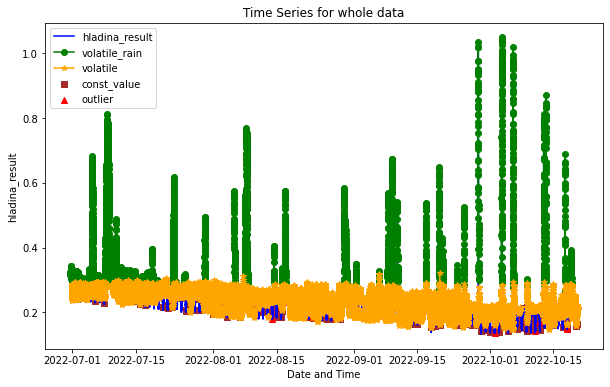

In [116]:
i+=1
print(sites[i])
classif_var = vars_of_interest[sites[i]][0]  #hladina
explorer.TS_objects[sites[i]].plot_categories(classif_var=classif_var)

MP7


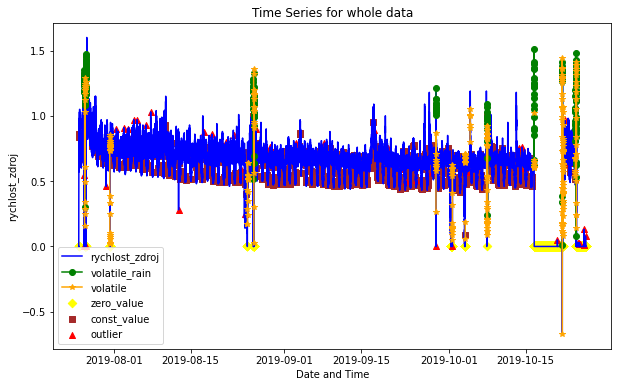

In [82]:
#i+=1
print(sites[i])
classif_var = vars_of_interest[sites[i]][1]  #rychlost
explorer.TS_objects[sites[i]].plot_categories(classif_var=classif_var)

MP7


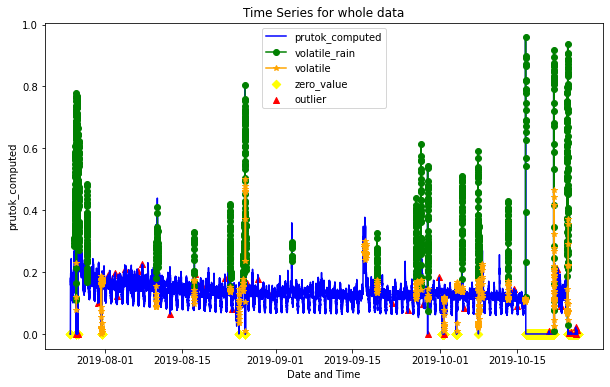

In [83]:
print(sites[i])
explorer.TS_objects[sites[i]].plot_categories()

In [37]:
indic = ts_data.data["prutok_computed"].rolling(10, center=True).apply(loc_extr)

In [549]:
ts_data.data["loc_peaks_10"] = np.where(indic, ts_data.data["prutok_computed"], np.nan)

In [ ]:
ts_data.plot(include=["loc_peaks_10"],marker="*",period=8)

In [564]:
ts_data_2 = TS_Class(ts_data.data,main_var="prutok_computed")

In [565]:
ts_data_2.classify(volatile_diffs=True)

In [569]:
ts_data.data["prutok_computed_volatile_rain_2"] = ts_data_2.data["prutok_computed_volatile_rain"]
ts_data.data["prutok_computed_volatile_2"] = ts_data_2.data["prutok_computed_volatile"]

In [ ]:
ts_data.plot(include=["prutok_computed_volatile_rain", "prutok_computed_volatile"], start_time_2 = "start",
            include_2 = ["prutok_computed_volatile_rain_2", "prutok_computed_volatile_2"], period=8)

In [507]:
trend = TS_Class.time_trend

In [509]:
ts_data.data["deriv2"] = ts_data.data["prutok_computed"].rolling(30, center=True).apply(lambda x: trend(x, degree=2))
ts_data.data["deriv3"] = ts_data.data["prutok_computed"].rolling(30, center=True).apply(lambda x: trend(x, degree=3))

In [534]:
ts_data.data["deriv4"] = ts_data.data["prutok_computed"].rolling(30, center=True).apply(lambda x: trend(x, degree=4))
ts_data.data["zero"] = 0

In [2]:
ts_data.data["prutok_computed_div10"] = ts_data.data["prutok_computed"]/10

NameError: name 'ts_data' is not defined

In [ ]:
ts_data.plot(variable="deriv", include=["deriv2","deriv3","deriv4","zero","prutok_computed_div10"], period = 8, 
             start_time_2 = "start", variable_2="prutok_computed")

# xx

In [28]:
i=-1

In [36]:
i+=1
site_dataframes[sorted(site_dataframes.keys())[i]]

,date,hladina_TL_zdroj,hladina_UZ_zdroj,hladina_result,prutok_computed,rychlost_result,rychlost_zdroj
0,2019-07-25 15:03:00,0.006,NaN,NaN,0.0000,NaN,0.00
1,2019-07-25 15:05:00,0.006,NaN,NaN,0.0000,NaN,0.00
2,2019-07-25 15:07:00,0.006,NaN,NaN,0.0000,NaN,0.00
3,2019-07-25 15:11:00,0.006,NaN,NaN,0.0000,NaN,0.00
4,2019-07-25 15:13:00,0.065,0.785,NaN,0.0294,NaN,0.14
...,...,...,...,...,...,...,...
66322,2019-10-25 23:51:00,0.253,0.246,0.25297,0.0000,0.52037,0.00
66323,2019-10-25 23:53:00,0.251,0.240,0.25097,0.0000,0.52037,0.00
66324,2019-10-25 23:55:00,0.251,0.243,0.25097,0.0000,0.52037,0.00
66325,2019-10-25 23:57:00,0.251,0.244,0.25097,0.0000,0.52037,0.00


In [31]:
for site in sorted(site_dataframes.keys()):
    print(site)
    df = site_dataframes[site]
    print(df.shape)
    print(site + " NAs:")
    print(df.isna().sum())
    print(f"{site} from {df['date'].min()} to {df['date'].max()}")
    print(site + " observation intervals:")
    print(df['date'].diff().dropna().value_counts())
    print(df["prutok_computed"].describe())

MP1
(80472, 7)
MP1 NAs:
date                  0
hladina_result        0
hladina_TL_zdroj    365
hladina_UZ_zdroj    364
prutok_computed       0
rychlost_result       0
rychlost_zdroj      365
dtype: int64
MP1 from 2022-06-30 13:12:00 to 2022-10-20 07:34:00
MP1 observation intervals:
0 days 00:02:00    80471
Name: date, dtype: int64
count    80472.000000
mean         0.184037
std          0.127910
min          0.052010
25%          0.125930
50%          0.163455
75%          0.196762
max          1.745810
Name: prutok_computed, dtype: float64
MP2
(66254, 7)
MP2 NAs:
date                   0
hladina_result         0
hladina_TL_zdroj    2092
hladina_UZ_zdroj    2092
prutok_computed        0
rychlost_result        0
rychlost_zdroj      2092
dtype: int64
MP2 from 2022-06-15 09:55:00 to 2022-09-15 10:21:00
MP2 observation intervals:
0 days 00:02:00    66253
Name: date, dtype: int64
count    66254.000000
mean         0.005588
std          0.010546
min          0.001350
25%          0.003350
5

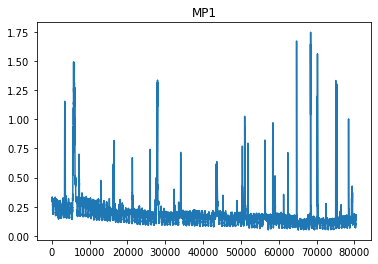

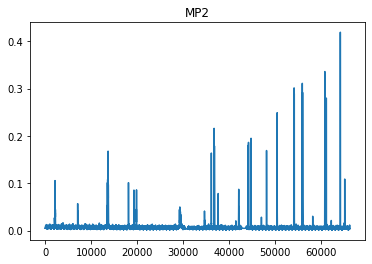

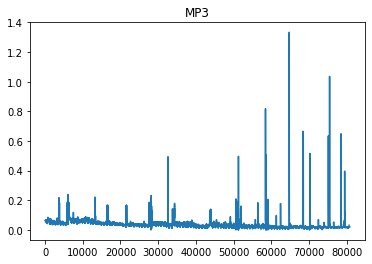

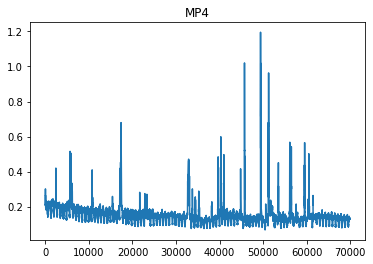

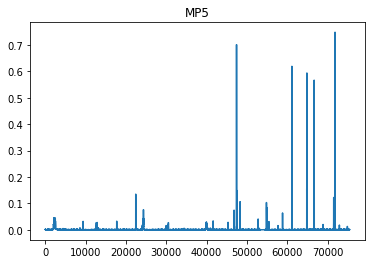

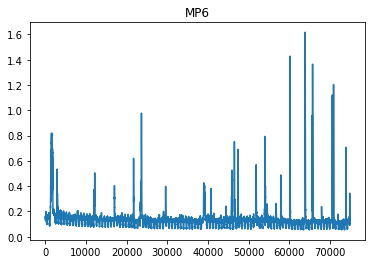

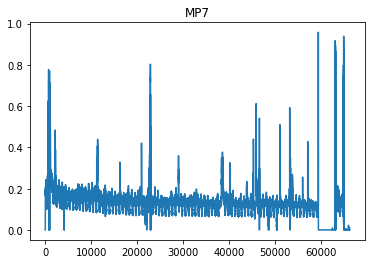

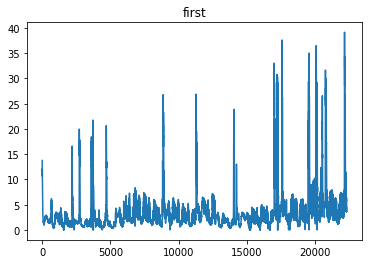

In [35]:
for site in sorted(site_dataframes.keys()):
    df = site_dataframes[site]
    df["prutok_computed"].plot(title = site)
    plt.show()
    plt.close()

## example of saving figures and plotting them again after some adjustments

In [ ]:
figs = ee.plot("prutok_computed_diff_1_",period=48, start_time_2 = "2:00:00", rain_var="rain_2m", window_2 = 80,
              ret_plots = True, include_2 = ["prutok_computed"])

In [ ]:
show_again = Plotter.show_again

for i, f in enumerate(figs):
    ax = f[1]
    ax[0].set_title(f"New Title Left {i+1}")
    ax[1].set_title(f"New Title Right {i+1}")

figures = [f[0] for f in figs]

show_again(figures)